# Evaluate models trained on patient-level snapshots

## Things to consider 

In the last notebook, I showed how to train models on patient snapshots using `patientflow`. Now, let's think about how to evaluate those models. 

When evaluating patient snapshots, we focus on:

* How well-calibrated the predicted probabilities are
* The distribution of these probabilities

We don't focus as much on typical classification metrics like Area under the ROC curve, accuracy or precision/recall. 

### Why don't we focus on typical classification metrics? 

The ultimate goal is to predict bed count distributions for groups of patients. Bed count distributions will be calculated in two steps

1. First, we predict the probability of the outcome we are interested in (admission or discharge) for each individual patient, as shown in previous notebooks.
2. Then, we use these probabilities in Bernoulli trials to get bed count distributions. The Bernouill trials step will be shown in later notebooks.

Because of this approach, the accuracy of the probability values matters more than correct classification. That is why we use log loss to optimise our classifiers. 

### About the data used in this notebook

I'm going to use real patient data from visits to the Emergency Department (ED) and Same Day Emergency Care (SDEC) unit at UCLH to demonstrate the evaluation. The methods shown will work on any data in the same structure. 

You can request the datasets that are used here on [Zenodo](https://zenodo.org/records/14866057). Alternatively you can use the synthetic data that has been created from the distributions of real patient data. If you don't have the public data, change the argument in the cell below from `data_folder_name='data-public'` to `data_folder_name='data-synthetic'`.




## Loading real patient data

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

The function below identifies the root of the patientflow repository, in order to locate the folders containing data.

In [24]:
import pandas as pd
from patientflow.load import set_file_paths, load_data

# set project root
from patientflow.load import set_project_root
project_root = set_project_root()

# set file paths
data_file_path, media_file_path, model_file_path, config_path = set_file_paths(
        project_root, 
        data_folder_name='data-public', # change this to data-synthetic if you don't have the public dataset
        verbose=False) 

# load the data
ed_visits = load_data(data_file_path, 
                    file_name='ed_visits.csv', 
                    index_column = 'snapshot_id',
                    sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                    eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])



Inferred project root: /Users/zellaking/Repos/patientflow


Inspecting the data that has been loaded, we can see that it is similar in structure to the fake data that was generated on the fly in the previous notebooks. The dates have been pushed into the future, to minimise the likelihood of re-identifcation of patients.

In [9]:
ed_visits.head()

,snapshot_date,prediction_time,visit_number,elapsed_los,sex,age_group,arrival_method,current_location_type,total_locations_visited,num_obs,num_obs_events,num_obs_types,num_lab_batteries_ordered,has_consultation,consultation_sequence,visited_majors,visited_otf,visited_paeds,visited_rat,visited_resus,visited_sdec,visited_sdec_waiting,visited_unknown,visited_utc,visited_waiting,num_obs_blood_pressure,num_obs_pulse,num_obs_air_or_oxygen,num_obs_glasgow_coma_scale_best_motor_response,num_obs_level_of_consciousness,num_obs_news_score_result,num_obs_manchester_triage_acuity,num_obs_objective_pain_score,num_obs_subjective_pain_score,num_obs_temperature,num_obs_oxygen_delivery_method,num_obs_pupil_reaction_right,num_obs_oxygen_flow_rate,num_obs_uclh_sskin_areas_observed,latest_obs_pulse,latest_obs_respirations,latest_obs_level_of_consciousness,latest_obs_news_score_result,latest_obs_manchester_triage_acuity,latest_obs_objective_pain_score,latest_obs_temperature,lab_orders_bc,lab_orders_bon,lab_orders_crp,lab_orders_csnf,lab_orders_ddit,lab_orders_ncov,lab_orders_rflu,lab_orders_xcov,latest_lab_results_crea,latest_lab_results_hctu,latest_lab_results_k,latest_lab_results_lac,latest_lab_results_na,latest_lab_results_pco2,latest_lab_results_ph,latest_lab_results_wcc,latest_lab_results_alb,latest_lab_results_htrt,training_validation_test,final_sequence,is_admitted,random_number,specialty
snapshot_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4/17/2031,"(12, 0)",30767,1920,F,55-64,Ambulance,majors,4,107,34,34,4,False,[],True,False,False,True,False,False,False,True,False,True,2,2,3,2,3,2,1,1,1,2,0,0,0,0,71.0,16.0,A,0.0,Yellow,Nil,98.2,False,False,True,False,False,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,[],False,15795,medical
1,4/17/2031,"(15, 30)",30767,14520,F,55-64,Ambulance,majors,5,138,39,34,6,False,[],True,False,False,True,False,False,False,True,False,True,4,5,6,3,6,3,1,1,1,3,0,0,0,0,48.0,16.0,A,0.0,Yellow,Nil,98.1,False,False,True,False,False,False,False,True,57.0,0.422,3.8,1.0,138.0,4.61,7.474,8.77,NaN,NaN,train,[],False,860,medical
2,12/10/2031,"(15, 30)",36297,9180,M,75-102,NaN,majors,4,127,12,37,8,False,[],True,False,False,True,True,False,False,True,False,False,7,6,7,7,7,6,1,1,1,6,0,0,0,0,63.0,22.0,A,2.0,Orange,Nil,97.5,False,False,True,True,False,False,False,False,97.0,0.483,4.1,1.2,140.0,4.82,7.433,6.59,NaN,NaN,test,[],False,76820,surgical
3,3/28/2031,"(6, 0)",53554,2220,F,35-44,Public Trans,rat,3,356,101,57,5,False,[],False,False,False,True,False,False,False,True,False,True,15,16,9,1,8,4,1,1,1,7,12,0,0,0,70.0,17.0,A,0.0,Green,Mild,97.7,False,False,True,True,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,[],False,54886,medical
4,3/28/2031,"(9, 30)",53554,14820,F,35-44,Public Trans,majors,4,375,107,57,7,False,[],True,False,False,True,False,False,False,True,False,True,16,17,10,1,9,5,1,1,1,8,12,0,0,0,65.0,17.0,A,0.0,Green,Mild,97.7,False,False,True,True,False,False,True,False,68.0,0.379,4.1,1.6,139.0,4.00,7.536,13.03,NaN,NaN,train,[],False,6265,medical


The dates for training, validation and test sets that match this dataset are defined in the config file in the root directory of `patientflow`.

In [17]:
#  
from patientflow.load import load_config_file
params = load_config_file(config_path)

start_training_set = params["start_training_set"]
print(f"Training set starts: {start_training_set}")

start_validation_set = params["start_validation_set"]
print(f"Validation set starts: {start_validation_set}")

start_test_set = params["start_test_set"] 
print(f"Test set starts: {start_test_set}")

end_test_set = params["end_test_set"]
print(f"Test set ends: {end_test_set}")


Training set starts: 2031-03-01
Validation set starts: 2031-09-01
Test set starts: 2031-10-01
Test set ends: 2032-01-01


## Train one model for each prediction time

First, we apply the temporal splits as shown in the previous notebook. 

In [18]:


from datetime import date   
from patientflow.prepare import create_temporal_splits

# create the temporal splits
train_visits, valid_visits, test_visits = create_temporal_splits(
    ed_visits,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="snapshot_date", # states which column contains the date to use when making the splits 
    visit_col="visit_number", # states which column contains the visit number to use when making the splits 

)


Split sizes: [53801, 6519, 19494]


Next we train a model for each prediction time.

In [19]:
prediction_times = [(6, 0), (9, 30), (12, 0), (15, 30), (22, 0)] 

print("\nNumber of observations for each prediction time")
print(ed_visits.prediction_time.value_counts())


Number of observations for each prediction time
prediction_time
(15, 30)    22279
(12, 0)     19075
(22, 0)     18842
(9, 30)     11421
(6, 0)       8197
Name: count, dtype: int64


As shown in the previous notebook, we define ordinal mappings where appropriate. These include:

* `age_group` - Age on arrival at the ED, defined in groups
* `latest_obs_manchester_triage_acuity` - Manchester Triage Score (where blue is the lowest acuity and red the highest)
* `latest_obs_objective_pain_score` - ranging from nil to very severe 
* `latest_obs_level_of_consciousness` the ACVPU measure of consciousness, where A (aware) and U (unconscious) at are the extremes. 

In [22]:
ordinal_mappings = {
    "age_group": [
        "0-17",
        "18-24",
        "25-34",
        "35-44",
        "45-54",
        "55-64",
        "65-74",
        "75-102",
    ],
    "latest_obs_manchester_triage_acuity": [
        "Blue",
        "Green",
        "Yellow",
        "Orange",
        "Red",
    ],
    "latest_obs_objective_pain_score": [
        "Nil",
        "Mild",
        "Moderate",
        "Severe_Very Severe",
    ],
    "latest_obs_level_of_consciousness": [
        "A", #alert
        "C", #confused
        "V", #voice - responds to voice stimulus
        "P", #pain - responds to pain stimulus
        "U" #unconscious - no response to pain or voice stimulus
    ]    }


In the real data, there are some columns that will be used for predicting admission to specialty, if admitted, that we don't use here. 

In [27]:
exclude_from_training_data = [ 'snapshot_date', 'prediction_time','visit_number', 'consultation_sequence', 'specialty', 'final_sequence', ]

We loop through each prediction time, training a model. To start with, we will not balance the dataset. 

In [29]:
from patientflow.train.classifiers import train_classifier

trained_models = []  

# Loop through each prediction time
for prediction_time in prediction_times:
    print(f"Training model for {prediction_time}")
    model = train_classifier(
        train_visits=train_visits,
        valid_visits=valid_visits,
        test_visits=test_visits,
        grid={"n_estimators": [20, 30, 40]},
        exclude_from_training_data=exclude_from_training_data,
        ordinal_mappings=ordinal_mappings,
        prediction_time=prediction_time,
        visit_col="visit_number",
        calibrate_probabilities=False,
        use_balanced_training=False,
    )
    
    trained_models.append(model)

(6, 0)
(9, 30)
(12, 0)
(15, 30)
(22, 0)


## Inspecting the base model

Below I show three different charts, all showing the calibration and distribution of the models, in slightly different ways. 

### Distribution plots

A distribution plot shows the spread of predicted probabilities for positive and negative cases.

* X-axis (Predicted Probability): Represents the model's predicted probabilities from 0 to 1.
* Y-axis (Density): Shows the relative frequency of each probability value.

The plot displays two histograms:

* Blue line/area: Distribution of predicted probabilities for negative cases (patients who weren't admitted)
* Orange line/area: Distribution of predicted probabilities for positive cases (patients who were admitted)

Ideal separation between these distributions indicates a well-performing model:

* Negative cases (blue) should cluster toward lower probabilities (left side)
* Positive cases (orange) should cluster toward higher probabilities (right side)

The degree of overlap between distributions helps assess model discrimination ability. Less overlap suggests the model effectively distinguishes between positive and negative cases, while significant overlap indicates areas where the model struggles to differentiate between outcomes.

From the plot below, we see that the model is discriminating poorly, with a high degree of overlap, and very few positive cases at the higher end. 


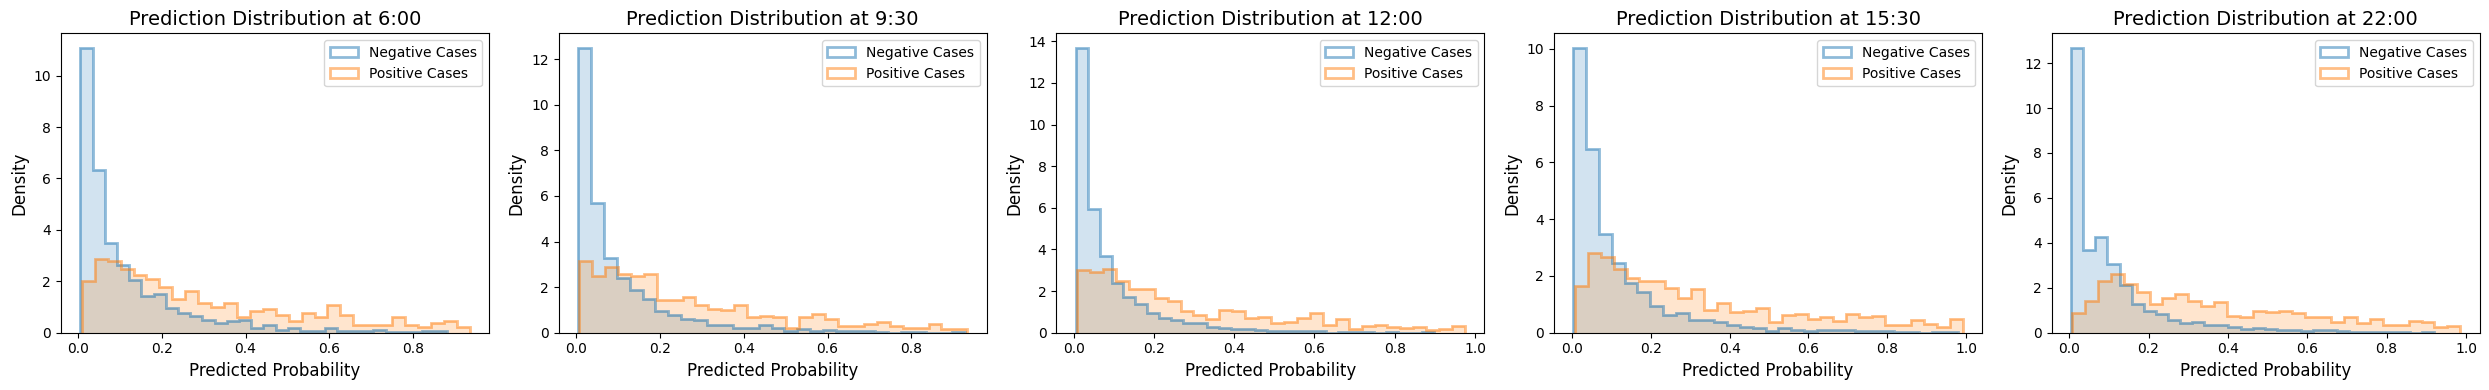

In [37]:
# without balanced training
from patientflow.viz.distribution_plots import plot_prediction_distributions
plot_prediction_distributions(
    trained_models=trained_models,  # Convert dict values to list
    test_visits=test_visits,
    exclude_from_training_data=exclude_from_training_data
)


### Calibration plots

A calibration plot shows how well a model's predicted probabilities match actual outcomes.

- X-axis (Mean Predicted Probability): The model's predicted probabilities, ordered from 0 to 1, grouped into bins, either using the uniform or the quantile strategy (see below).
- Y-axis (Fraction of Positives): The observed proportion of admissions for visits in that group.

A perfectly calibrated model would align its points along the diagonal line, meaning a 70% predicted probability means the event happens 70% of the time.

Uniform vs Quantile Strategies:
- Uniform: Divides predictions into equal-width probability bins (e.g., 0.0-0.1, 0.1-0.2), so some bins may have few or many points.
- Quantile: Ensures each bin has the same number of predictions, regardless of how wide or narrow each bin's probability range is.

Below, we see reasonable calibration at the lower end, but deteriorating towards the higher end.

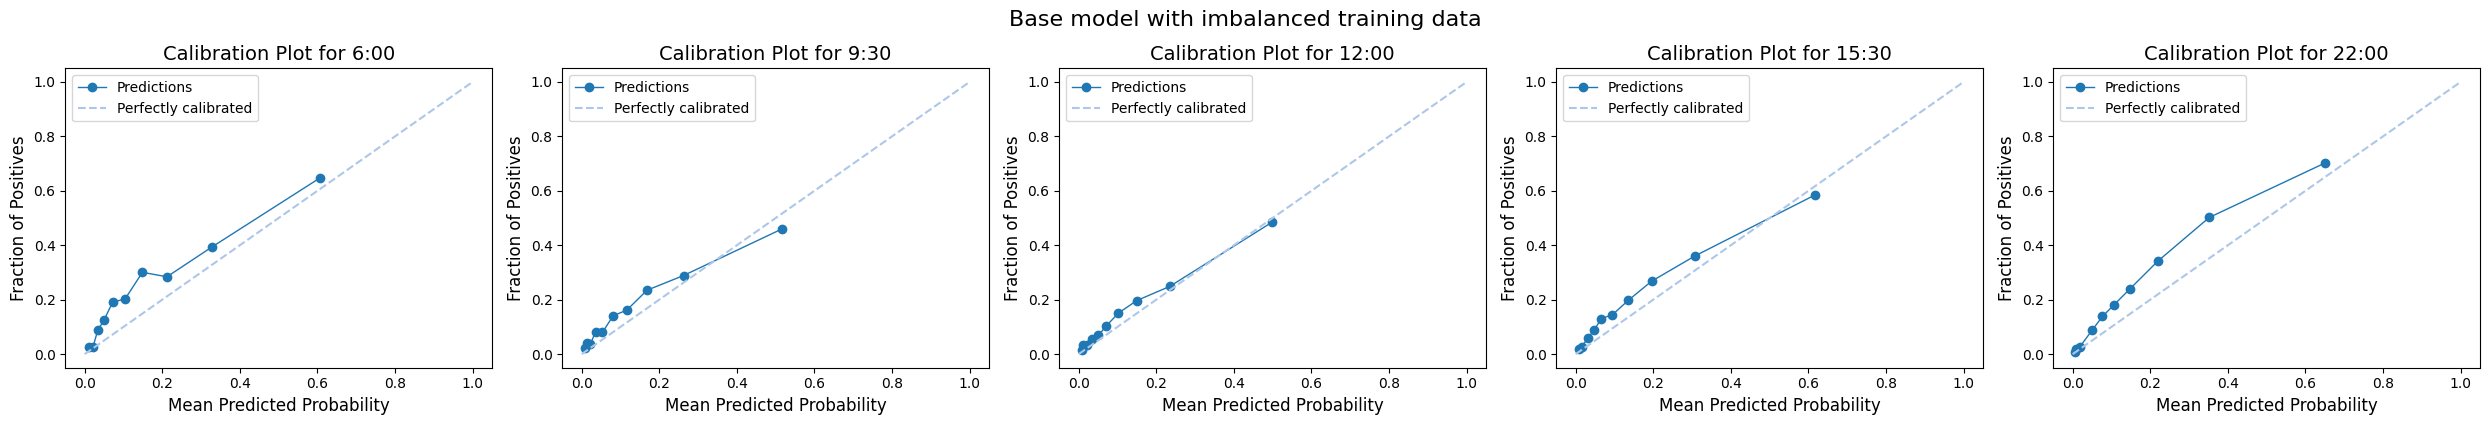

In [40]:
# without balanced training
from patientflow.viz.calibration_plot import plot_calibration

plot_calibration(
    trained_models=trained_models,  # Convert dict values to list
    test_visits=test_visits,
    exclude_from_training_data=exclude_from_training_data,
    strategy="quantile",  # optional
    suptitle="Base model with imbalanced training data"  # optional
)

### MADCAP (Model Accuracy Diagnostic Calibration Plot)

A MADCAP (Model Accuracy Diagnostic Calibration Plot) visually compares the predicted probabilities from a model with the actual outcomes (e.g., admissions or events) in a dataset. This plot helps to assess how well the model's predicted probabilities align with the observed values.

The blue line represents the cumulative predicted outcomes, which are derived by summing the predicted probabilities as we move through the test set, ordered by increasing probability.
The orange line represents the cumulative observed outcomes, calculated based on the actual labels in the dataset, averaged over the same sorted order of predicted probabilities.

If the model is well calibrated, these two lines will closely follow each other, and the curves will bow to the bottom left. 

Below, we see that the models under-predict the likelihood of admissions, as the blue line (predicted outcomes) consistently falls below the orange line (actual outcomes). The models are systematically assigning lower probabilities than it should, meaning that (later) we will under-predict the number of beds needed for these patients.

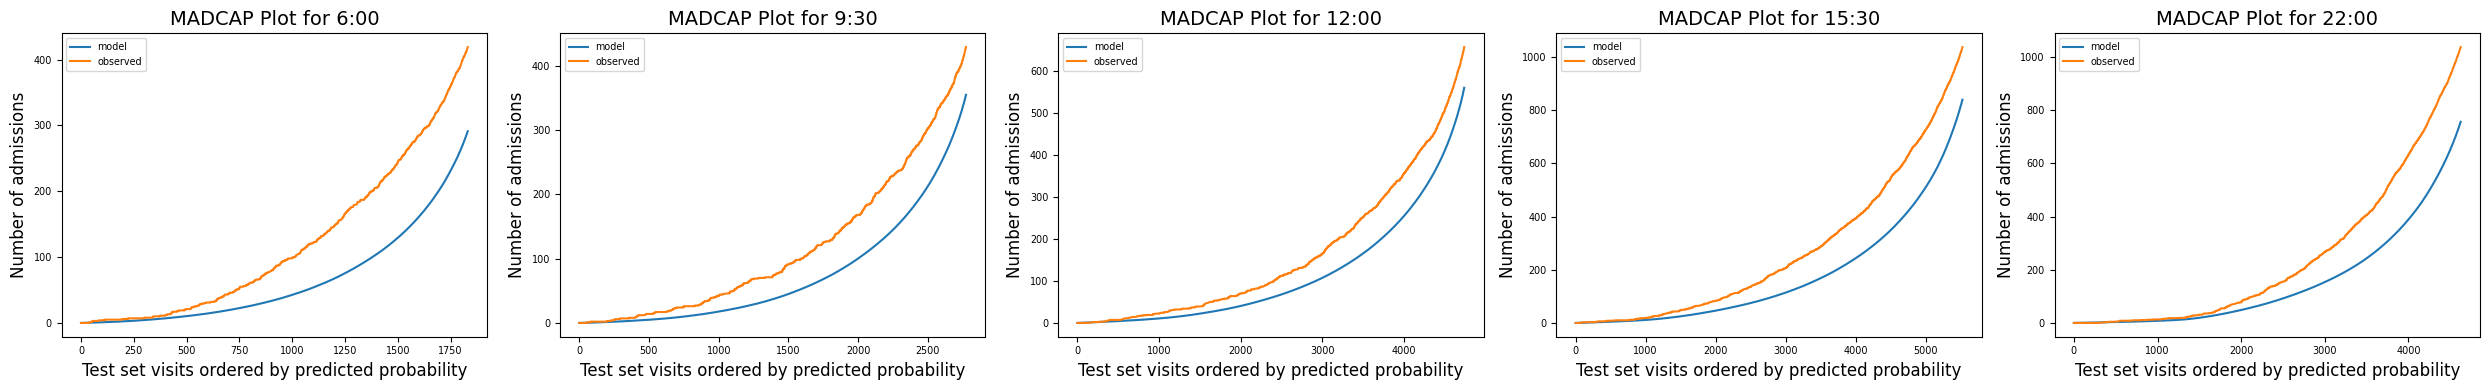

In [39]:
## without balanced training
from patientflow.viz.madcap_plot import generate_madcap_plots
generate_madcap_plots(
    trained_models=trained_models,
    test_visits=test_visits,
    exclude_from_training_data=exclude_from_training_data
)

## Inspecting a balanced and calibrated model

In the previous notebook I showed that the `train_classifier()` function will balance the training set, by under-sampling the negative class, and then re-calibrate the data using the validation set. Below I train the models with these arguments set to true, and re-run the plots. 

In [42]:
from patientflow.train.classifiers import train_classifier

trained_models = []  

# Loop through each prediction time
for prediction_time in prediction_times:
    print(f"Training model for {prediction_time}")
    model = train_classifier(
        train_visits=train_visits,
        valid_visits=valid_visits,
        test_visits=test_visits,
        grid={"n_estimators": [20, 30, 40]},
        exclude_from_training_data=exclude_from_training_data,
        ordinal_mappings=ordinal_mappings,
        prediction_time=prediction_time,
        visit_col="visit_number",
        calibrate_probabilities=True,
        calibration_method="sigmoid",
        use_balanced_training=True,
    )
    
    trained_models.append(model)



Training model for (6, 0)
Training model for (9, 30)
Training model for (12, 0)
Training model for (15, 30)
Training model for (22, 0)


From the plots below, we see improved discrimination. There are positive cases clustered at the right hand end of the distribution plot, and the MADCAP lines are closer. The model slightly underpredicts at 06:00, 09:30 and 22:00, and slightly overpredicts at 12:00 and 15:30. These improvements have been achieved while maintaining good calibration.   

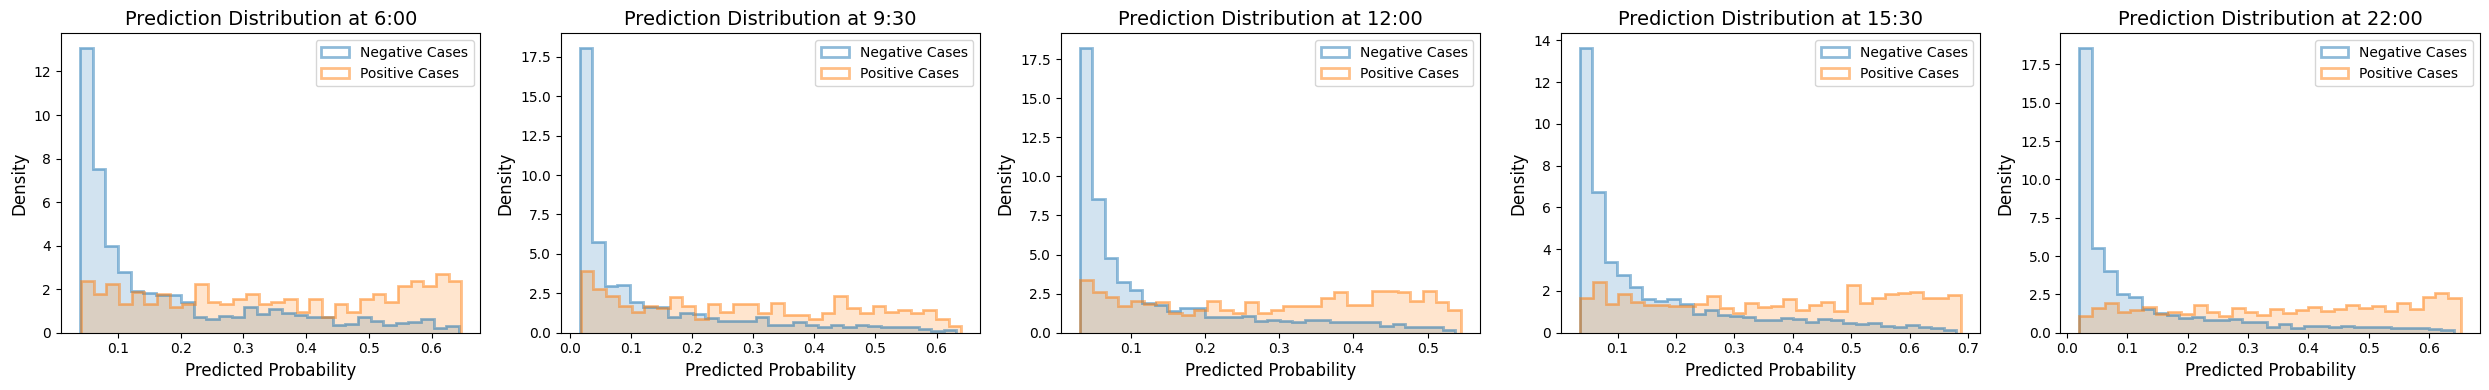

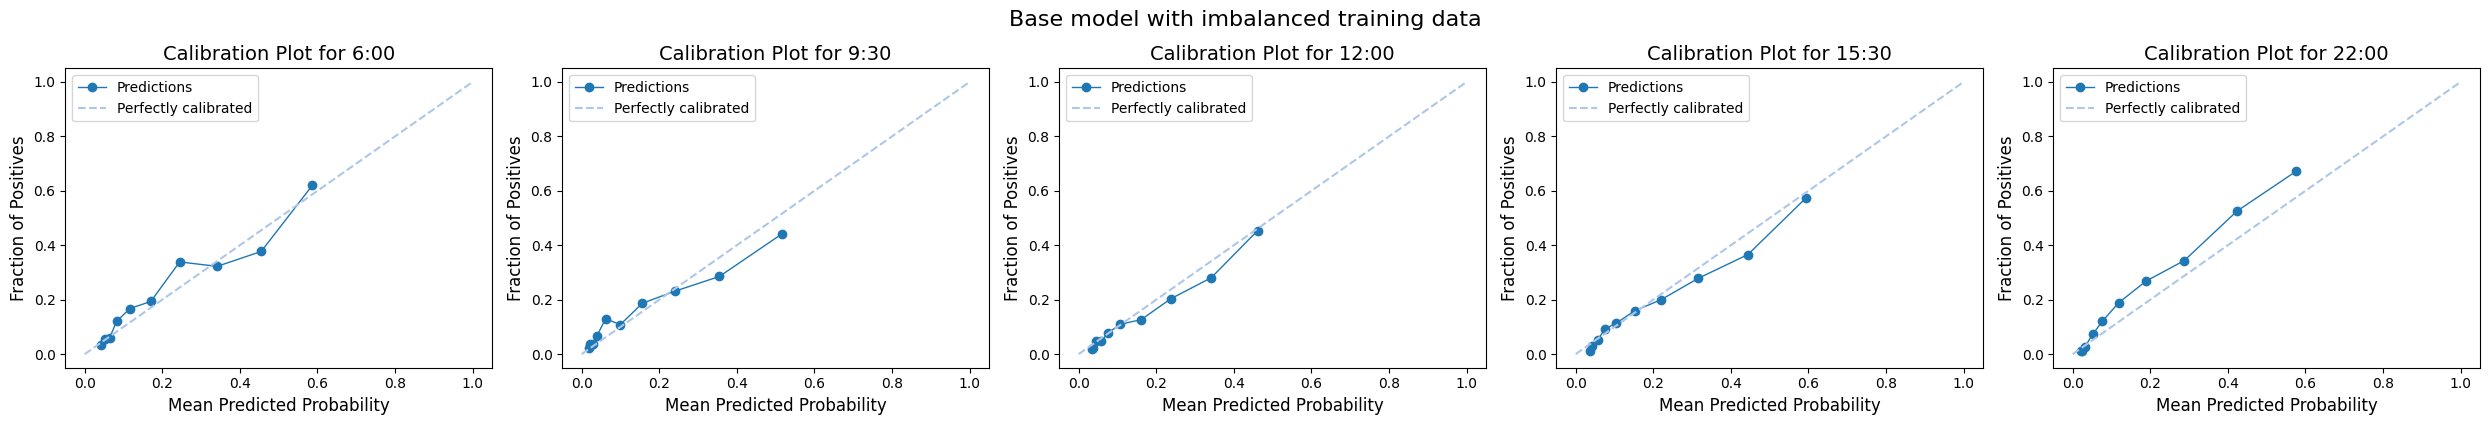

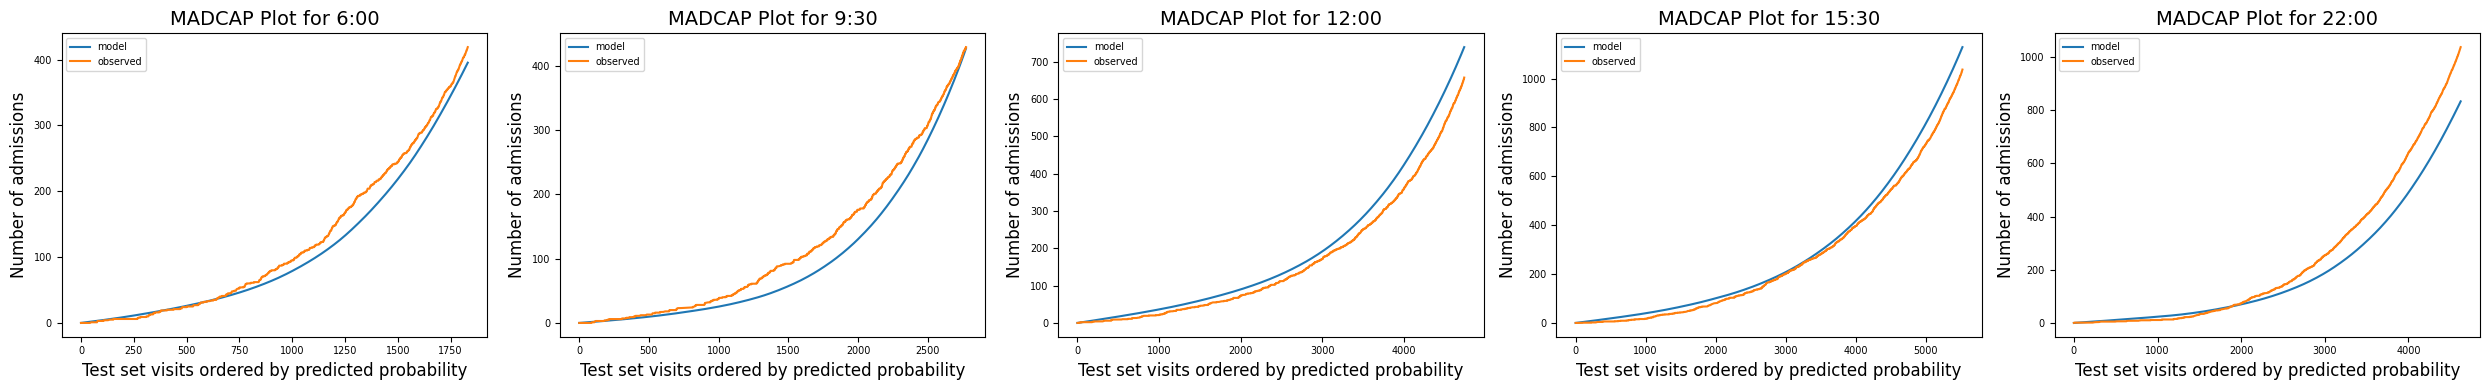

In [43]:
plot_prediction_distributions(
    trained_models=trained_models,  # Convert dict values to list
    test_visits=test_visits,
    exclude_from_training_data=exclude_from_training_data
)
plot_calibration(
    trained_models=trained_models,  # Convert dict values to list
    test_visits=test_visits,
    exclude_from_training_data=exclude_from_training_data,
    strategy="quantile",  # optional
    suptitle="Base model with imbalanced training data"  # optional
)

generate_madcap_plots(
    trained_models=trained_models,
    test_visits=test_visits,
    exclude_from_training_data=exclude_from_training_data
)

## MADCAP plots by age

It can be useful to look at sub-categories of patients, to understand whether models perform better for some groups. Here we show MADCAP plots by age group.

The performance is worse for children over all. There are fewer of them in the data, which can be seen by comparing the y axis limits. The y axis maximum is the total number of snapshots in the test that were in at the prediction time. In general, there are twice as many adults as over 65s (except at 22:00), and very few children. The models perform poorly for children, and best for adults under 65. They tend to under-predict for older people, especially at 22:00 and 06:00.  

Analysis like this helps understand the limitations of the modelling, and consider alternative approaches. For example, we might consider training a different model for older people, if there was enough data, or gathering more training data before deployment. 


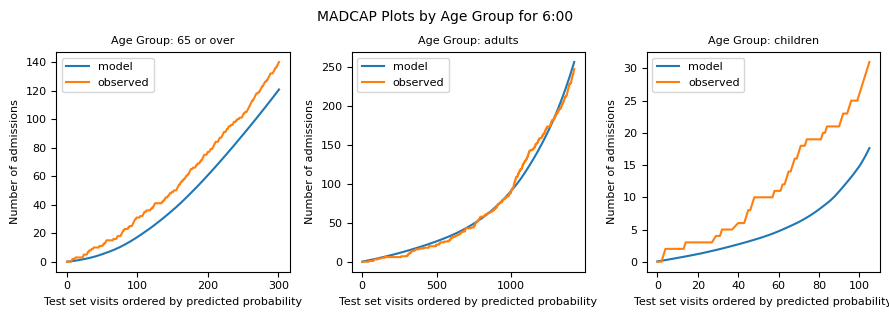

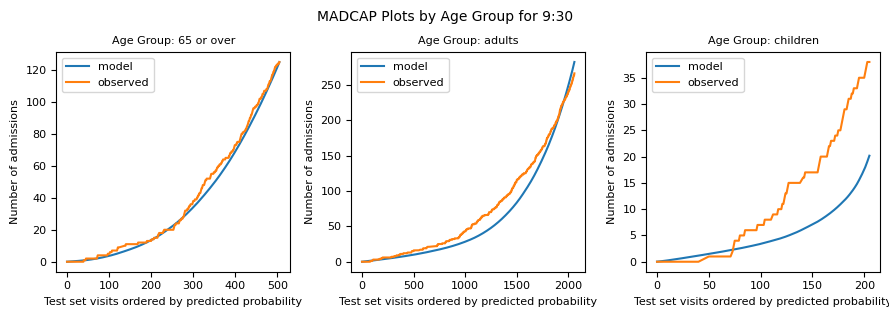

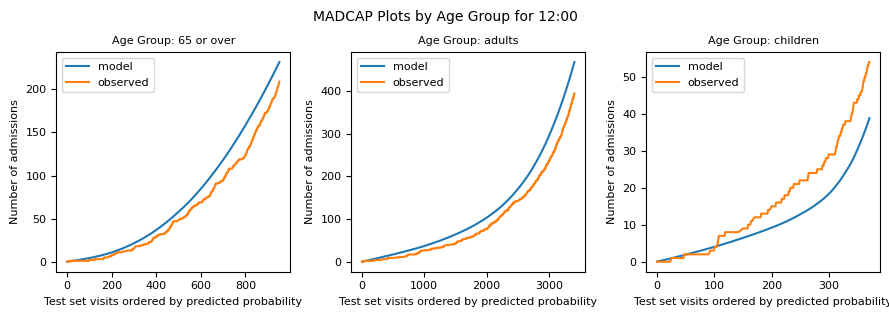

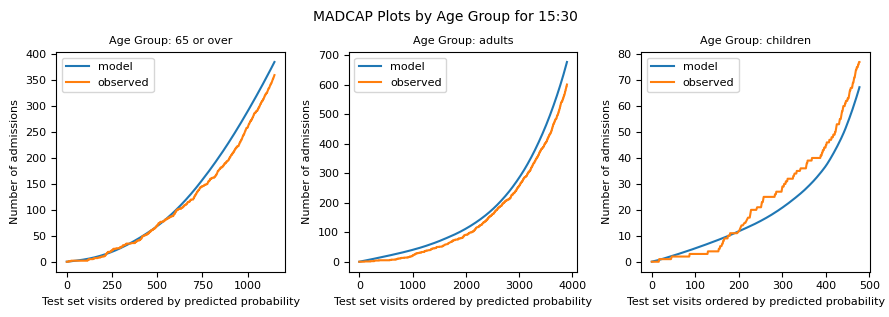

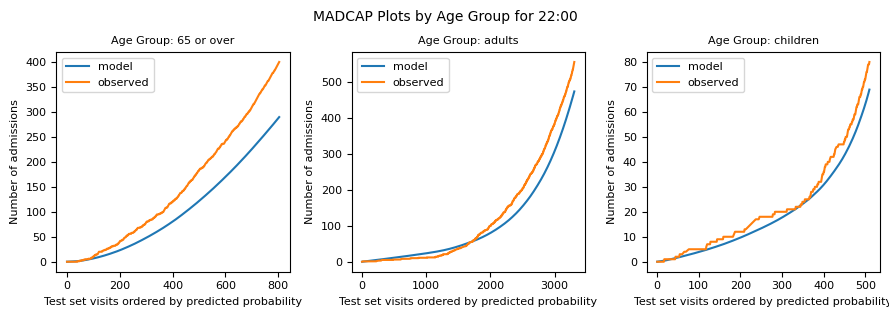

In [45]:
from patientflow.viz.madcap_plot import generate_madcap_plots_by_group
generate_madcap_plots_by_group(
    trained_models=list(trained_models),
    test_visits=test_visits,
    exclude_from_training_data=exclude_from_training_data,
    grouping_var="age_group",
    grouping_var_name="Age Group",
    plot_difference=False
)

## Conclusion

Here I have shown how visualations within `patientflow` can help you

* assess the discrimination and calibration of your models
* identify areas of weakness in your models by comparing predictions across different patient groups

I have also shown how using balanced training set, and re-calibrating using the validation set, can help to improve the discrimination of models where you start with imbalanced data. This is common in healthcare data. 

This notebook concludes the set covering patient snapshots. We have created predicted probabilities for each patient, based on what is known about them at the time of the snapshot. However, bed managers really want predictions for the whole cohort of patients at a time. This is where `patientflow` comes into its own. In the next notebook, I show how to create group snapshots. 